<div class="alert alert-block alert-info">
    <h1>Natural Language Processing</h1>
    <h3>General Information:</h3>
    <p>Please do not add or delete any cells. Answers belong into the corresponding cells (below the question). If a function is given (either as a signature or a full function), you should not change the name, arguments or return value of the function.<br><br> If you encounter empty cells underneath the answer that can not be edited, please ignore them, they are for testing purposes.<br><br>When editing an assignment there can be the case that there are variables in the kernel. To make sure your assignment works, please restart the kernel and run all cells before submitting (e.g. via <i>Kernel -> Restart & Run All</i>).</p>
    <p>Code cells where you are supposed to give your answer often include the line  ```raise NotImplementedError```. This makes it easier to automatically grade answers. If you edit the cell please outcomment or delete this line.</p>
    <h3>Submission:</h3>
    <p>Please submit your notebook via the web interface (in the main view -> Assignments -> Submit). The assignments are due on <b>Wednesday at 15:00</b>.</p>
    <h3>Group Work:</h3>
    <p>You are allowed to work in groups of up to two people. Please enter the UID (your username here) of each member of the group into the next cell. We apply plagiarism checking, so do not submit solutions from other people except your team members. If an assignment has a copied solution, the task will be graded with 0 points for all people with the same solution.</p>
    <h3>Questions about the Assignment:</h3>
    <p>If you have questions about the assignment please post them in the LEA forum before the deadline. Don't wait until the last day to post questions.</p>
    
</div>


# Word Embeddings

In this assignment we want to create word embeddings (vectors) from a corpus and use them to build a simple document classifier.

For this we will use a subset of the Yelp restaurant dataset. 

The dataset contains a list of reviews, where each review is a dictionary with the following fields:

- ```id```: An integer denoting the id of the review
- ```text```: The original review as a single string
- ```stars```: How the place was rated from 1 (worst) to 5 (best)
- ```tokens```: The tokenized and cleaned review. All tokens have been converted to lower case.

There are two datasets, ```reviews_train``` consisting of 400 reviews (80 per rating) and ```reviews_test``` consisting of 100 reviews (20 per rating).

The following cell shows how to load the datasets into the variables ```train``` and ```test```.


**Attention: This assignment might look like a lot of tasks but you will be able to reuse a lot of answers from the One Hot Embedding tasks for the TfIdf Embedding task**

In [2]:
import pickle

with open('/srv/shares/NLP/reviews_train.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('/srv/shares/NLP/reviews_test.pkl', 'rb') as f:
    test = pickle.load(f)
    
# Print a review
train[358]

{'id': 438,
 'text': "Absolutely ridiculously amazing! Chicken Tikka masala was perfect. Best I've ever had!",
 'tokens': ['absolutely',
  'ridiculously',
  'amazing',
  'chicken',
  'tikka',
  'masala',
  'was',
  'perfect',
  'best',
  'i',
  'ever',
  'had'],
 'stars': 5}

## One Hot Enconding

Perhabs the simplest way to build word embeddings is by using one hot vectors. These are vectors with a length of $|V|$ where $V$ is our vocabulary (the types from our corpus). The vocabulary should be an alphabetically sorted list of types.

A one hot vector consists of mostly zeros with a single one at the index of the word in the vocabulary. 

*Example:*

Assume we have the vocabulary ```['a', 'dog', 'i', 'have']```. Then the embedding for the word ```a``` would be $[1, 0, 0, 0]$. The embedding for the word ```i``` would be $[0, 0, 1, 0]$.

### One Hot Encoding A) [15 points]

Complete the class ```OneHotModel```.

This class has the following three methods:

- ```build_index```: Takes a list of documents (each being a list of tokens). Then it creates the dictionary ```self.index``` which maps each type to an index. In the example above the dictionary would look like this:
```self.index = {'a': 0, 'dog': 1, 'i': 2, 'have': 3}```

- ```train```: Takes a list of documents (each being a list of tokens). This should train the one hot model such that it can return vectors for each type in the corpus

- ```embed```: Take a single word and return a one hot encoded vector for that word. If the word is not in the index it should return ```None```


Please complete the three methods of the class.

In [3]:
from typing import List
from abc import ABC, abstractmethod
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Abstract super class for all embedding models we build, do not edit this
class EmbeddingModel(ABC):
    
    @abstractmethod
    def train(self, docs: List[List[str]]) -> None:
        pass
    
    @abstractmethod
    def embed(self, word: str) -> np.ndarray:
        pass
    
    @abstractmethod
    def vector_size(self) -> int:
        pass


class OneHotModel(EmbeddingModel):
    
    def build_index(self, docs: List[List[str]]) -> None:
        '''
        Create an index for the vocabulary from the docs
        
        Args:
            docs -- A list of documents where each document is a list of tokens
        '''
        self.index = dict()
    
        # Use list comprehension to convert a list of lists to a flat list 
        self.sorted_list = []
        self.sorted_list = [w for s in docs for w in s]
        
        # Sorting the list in ascending order
        self.sorted_list = sorted(list(set(self.sorted_list)))
        
        # Create dictionary for sorted list with index
        self.index = {j:i for i,j in enumerate(self.sorted_list)}
        
    
    def train(self, docs: List[List[str]]) -> None:
        '''
        Train our model with a list of documents
        
        Args:
            docs -- A list of documents where each document is a list of tokens
        '''
        self.build_index(docs)
        
        # Creating list for storing vectors
        self.vectors = []
        for row in np.eye(len(self.sorted_list),dtype=int):
            self.vectors.append(row)
        
        # Creating dictionary with sorted list and vectors
        self.dictt = dict(zip(self.sorted_list,self.vectors))
        
        
    def embed(self, word: str) -> np.ndarray:
        '''
        Embed a word into our one hot vector space
        If the word is not in the index it will return None
        
        Args:
            word      -- The word we want an embedding for
        Returns:
            embedding -- The one hot encoded vector for the word
        '''
        if word in self.index:
            return self.vectors[self.index[word]]
        else:
            return None
                
        
    def vector_size(self) -> int:
        '''
        Return the length of the embedding
        '''
        return len(self.index)

In [4]:
# This is a test cell, please ignore it

### One Hot Encoding B) [10 points]

We now want to use our model to create one hot vectors for each type in our training dataset ```train```.

After training we want to create document embeddings using the bag-of-words approach. For this you need to complete a function called ```bagOfWords``` which takes in a document as a list of strings and our one hot model, maps each token of the document to a one hot vector and sums them up. 

The document embedding is then the sum of all word embeddings in the document divided by the number of tokens in the document that are present in our model.

In [5]:
def bagOfWords(model: EmbeddingModel, doc: List[str]) -> np.ndarray:
    '''
    Create a document embedding using the bag of words approach
    
    Args:
        model     -- The embedding model to use
        doc       -- A document as a list of tokens
        
    Returns:
        embedding -- The embedding for the document as a single vector 
    '''
    sum_array = np.zeros(model.vector_size())
    number_of_tokens = 0
    for word in doc:
        vector = model.embed(word)
        if vector is not None:
            number_of_tokens +=1
            sum_array = np.add(sum_array,vector)
    embeded_vector = sum_array/number_of_tokens
    return embeded_vector


# Create a one hot model and train it on a dummy corpus
model = OneHotModel()
corpus = [['i', 'like', 'pizza'],
          ['do', 'you', 'like', 'pizza'],
          ['everybody', 'likes', 'pizza', 'or', 'fries']]

# Train the model on the corpus
model.train(corpus)

# Create a document embedding for the sample document
doc = ['you','like', 'fries']

# This should create the embedding: [0, 0, 0.33333333, 0, 0.33333333, 0, 0, 0, 0.33333333]
print(bagOfWords(model, doc))

[0.         0.         0.33333333 0.         0.33333333 0.
 0.         0.         0.33333333]


In [6]:
# This is a test cell, please ignore it

### One Hot Encoding C) [10 points]

Train your OneHotModel on the reviews from the training set.

Then create the following matrices / vectors from the training and test dataset:

- ```embed_train```: A 2-dimensional numpy array where the rows are the document embeddings for each document in the training set
- ```labels_train```: A 1-dimensional numpy array where each element is the rating (stars) of the review from the training set. The rating at position 3 should correspond to the third row of the ```embed_train``` matrix.
- ```embed_test```: A 2-dimensional numpy array where the rows are the document embeddings for each document in the test set
- ```labels_test```: A 1-dimensional numpy array where each element is the rating (stars) of the review from the test set. The rating at position 3 should correspond to the third row of the ```embed_test``` matrix.

In [7]:
model = OneHotModel()
model.train([review['tokens'] for review in train])

embed_train = np.array([[]])
labels_train = np.array([])

embed_test = np.array([[]])
labels_test = np.array([])

# Training set
training_set = [review['tokens'] for review in train]
embed_train = np.zeros_like(bagOfWords(model,training_set[0]))
# Stacking the tokens and vectors vertically side by side for training set
for i in training_set:
    embed_train = np.vstack((embed_train,bagOfWords(model,i)))
embed_train = embed_train[1:,:]
# Labels containing 'stars' 
labels_train = [review['stars'] for review in train]
labels_train = np.reshape(labels_train,(-1,1))

# Test set
testing_set = [review['tokens'] for review in test]
embed_test = np.zeros_like(bagOfWords(model,testing_set[0]))
# Stacking the tokens and vectors vertically side by side for test set
for i in testing_set:
    embed_test = np.vstack((embed_test,bagOfWords(model,i)))
embed_test = embed_test[1:,:]
# Labels containing 'stars' 
labels_test = [review['stars'] for review in test]
labels_test = np.reshape(labels_test,(-1,1))


print(embed_train.shape)  # Should print (400, 5497)
print(labels_train.shape) # Should print (400, )
print(embed_test.shape)   # Should print (100, 5497)
print(labels_test.shape)  # Should print (100, )

(400, 5497)
(400, 1)
(100, 5497)
(100, 1)


In [8]:
# This is a test cell, please ignore it

### One Hot Encoding D) [10 points]

With the matrices and vectors we just created we can train a simple classifier such as a Support Vector Machine for multi-class classification. 

For this we will use an implementation from sklearn ```sklearn.svm.SVC```. Each model from sklearn has two main methods:

- ```fit```: Takes in a matrix like our ```embed_train``` matrix and a vector like our ```labels_train``` vector and trains the classifier on the data

- ```predict```: Takes in a single data vector (like our document vectors) and predicts the label

A nice way of presenting the performance of a classifier is to use a confusion matrix. This is a matrix where the rows show the correct label and columns the predicted label. A perfect classifier would have all samples on the main diagonal and all zeros else.

Luckily ```sklearn``` already provides us with a function to plot a confusion matrix ```sklearn.metrics.plot_confusion_matrix```. This takes in a trained classifier, a matrix of samples and a vector of true labels.

Your task is now to:

- Train the SVM Classifier (SVC) on your training data with standard parameters
- Plot a confusion matrix for the training set
- Plot a confusion matrix for the test set
- Add a title to each confusion matrix

Bonus Task:

Calculate the f1_score using the 'micro' average. [2 points]

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


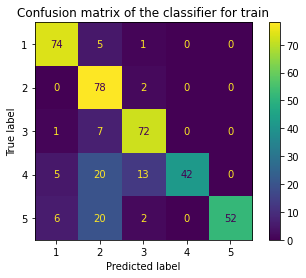

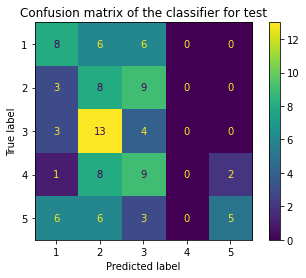

F1-score for training set 0.795
F1-score for testing set 0.25


In [9]:
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, f1_score

classifier = SVC(kernel='poly')
classifier.fit(embed_train,labels_train)

plot_confusion_matrix(classifier, embed_train,labels_train)
plt.title('Confusion matrix of the classifier for train')
plot_confusion_matrix(classifier, embed_test,labels_test)
plt.title('Confusion matrix of the classifier for test')
plt.show()

pred_train_set = np.array(classifier.predict(embed_train).reshape(-1,1))
pred_test_set = np.array(classifier.predict(embed_test).reshape(-1,1))

print("F1-score for training set",f1_score(labels_train,pred_train_set, average='micro'))
print("F1-score for testing set",f1_score(labels_test,pred_test_set, average='micro'))

### One Hot Encoding E) [5 points]

Discuss the performance of your classifier and reason why the performance is the way it is.

F1 score for training set is better compared to testing test. Higher value of F1-score denotes better performance of the model. The model performs better during training and less efficient during testing. This change in performance is due to overfitting of the data.

## TfIdf Enconding

Another way of creating word embeddings is to use tfidf embeddings.

For this we need a set of documents from which we create a tfidf matrix. The rows of the matrix correspond to the terms while the columns correspond to the documents (see Figure 6.8 in the chapter *Vector Semantics and Embeddings*). The embedding for a certain word is then the row corresponding to that word in the tfidf matrix.

We use the following equation to calculate the tfidf values:  

$\mathrm{tfidf}(t, d) = \mathrm{tf}(t, d) * \mathrm{idf}(t, d)$  
$\mathrm{tf}(t, d) = \mathrm{log}_{10}(\mathrm{count}(t, d) + 1)$  
$\mathrm{idf}(t, d) = \mathrm{log}_{10}\frac{N}{\mathrm{df}(t)}$  
$\mathrm{df}(t) = $ number of documents $t$ appears in

*Rough outline of the algorithm to create a tfidf matrix*:

1. Start by building a term document matrix. Each entry in the matrix tells us how often a term $t$ appears in the document $d$.
2. Convert each element in the matrix into a $\mathrm{tf}$ value by applying the logarithm
3. Create a df vector from that matrix. This tells us for each term in how many documents it appears
4. Create an idf vector from the df vector
5. Multiply each row of the matrix create in step 2. by the idf value for that term.

### TfIdf Encoding A) [30 points]

Complete the class ```TfIdfModel```.

This class has the following three methods:

- ```build_index```: Takes a list of documents (each being a list of tokens). Then it creates the dictionary ```self.index``` which maps each type to an index. In the example above the dictionary would look like this:
```self.index = {'a': 0, 'dog': 1, 'i': 2, 'have': 3}```. You can copy your code from the OneHotModel for this function.

- ```train```: Takes a list of documents (each being a list of tokens). This should train the tfidf model such that it can return vectors for each type in the corpus

- ```embed```: Take a single word and return a tfidf vector for that word. If the word is not in the index it should return ```None```


Please complete the three methods of the class.

In [10]:
from typing import List
from collections import Counter
import numpy as np

class TfIdfModel(EmbeddingModel):
    
    def build_index(self, docs: List[List[str]]) -> None:
        '''
        Create an index for the vocabulary from the docs
        
        Args:
            docs -- A list of documents where each document is a list of tokens
        '''
        self.index = dict()
    
        # Use list comprehension to convert a list of lists to a flat list 
        self.sorted_list = []
        self.sorted_list = [w for s in docs for w in s]
        
        # Sorting the list in ascending order
        self.sorted_list = sorted(list(set(self.sorted_list)))
        
        # Create dictionary for sorted list with index
        self.index = {j:i for i,j in enumerate(self.sorted_list)}
    
    def train(self, docs: List[List[str]]) -> None:
        '''
        Train our model with a list of documents
        
        Args:
            docs -- A list of documents where each document is a list of tokens
        '''
        
        self.build_index(docs)
        # Create an empty tfidf matrix
        self.tfidf_matrix = np.zeros((len(self.index), len(docs)))
        # Create an empty term document matrix
        term_doc_matrix = np.zeros((len(self.index), len(docs)))
        # Create an empty df vector
        idf_vector = np.zeros(len(self.index))
        
        tf_vector = np.zeros((len(self.index), len(docs)))
        
        for vocab in self.index:
            for doc_id in range(len(docs)):
                for token in docs[doc_id]:
                    if token == vocab:
                        term_doc_matrix[self.index[vocab]][doc_id] +=1
        
        for vocab in self.index:
            for doc_id in range(len(docs)):
                tf_vector[self.index[vocab]][doc_id] = np.log10((term_doc_matrix[self.index[vocab]][doc_id])+1)#   /len(docs[doc_id]     
        
        for row in range(len(term_doc_matrix)):
                idf_vector[row] = np.log10(len(docs)/np.sum(term_doc_matrix[row]))
        
        for vocab in self.index:
            for doc_id in range(len(docs)):                                           
                    self.tfidf_matrix[self.index[vocab]]= (tf_vector[self.index[vocab]]* idf_vector[self.index[vocab]])

    
    def embed(self, word: str) -> np.ndarray:
        '''
        Embed a word into our tfidf vector space
        If the word is not in the index it will return None
        
        Args:
            word      -- The word we want an embedding for
        Returns:
            embedding -- The tfidf embedding for the word
        '''
        # YOUR CODE HERE
        for key in self.index:
            if key == word:
                return self.tfidf_matrix[self.index[key]]
        return None
       
    def vector_size(self) -> int:
        return self.tfidf_matrix.shape[1]

In [11]:
# Here you can verify the working of your tfidf model

# Create a tfidf model and train it on a dummy corpus
model = TfIdfModel()
corpus = [['i', 'like', 'pizza'],
          ['do', 'you', 'like', 'pizza'],
          ['everybody', 'likes', 'pizza', 'or', 'fries']]

# Train the model on the corpus
model.train(corpus)

'''Show the index of the model
Should be: 
{'do': 0, 'everybody': 1, 
 'fries': 2, 'i': 3, 
 'like': 4, 'likes': 5,
 'or': 6, 'pizza': 7, 'you': 8}
'''
print('The index of your model is:')
print(model.index)
print()

# Create a document embedding for the sample document
doc = ['you', 'like', 'fries']

# This should create the embedding: [0.05869709, 0.2177375 , 0.15904042])
print(f'The document embedding for {doc} is:')
print(bagOfWords(model, doc))
print()

# Show the internal tfidf matrix for this corpus:
'''
Expected is:
array([[0.        , 0.47712125, 0.        ],
       [0.        , 0.        , 0.47712125],
       [0.        , 0.        , 0.47712125],
       [0.47712125, 0.        , 0.        ],
       [0.17609126, 0.17609126, 0.        ],
       [0.        , 0.        , 0.47712125],
       [0.        , 0.        , 0.47712125],
       [0.        , 0.        , 0.        ],
       [0.        , 0.47712125, 0.        ]])
'''

print('Tfidf matrix of your model:\n', model.tfidf_matrix)

The index of your model is:
{'do': 0, 'everybody': 1, 'fries': 2, 'i': 3, 'like': 4, 'likes': 5, 'or': 6, 'pizza': 7, 'you': 8}

The document embedding for ['you', 'like', 'fries'] is:
[0.01766958 0.06554552 0.04787594]

Tfidf matrix of your model:
 [[0.         0.14362781 0.        ]
 [0.         0.         0.14362781]
 [0.         0.         0.14362781]
 [0.14362781 0.         0.        ]
 [0.05300875 0.05300875 0.        ]
 [0.         0.         0.14362781]
 [0.         0.         0.14362781]
 [0.         0.         0.        ]
 [0.         0.14362781 0.        ]]


In [12]:
# This is a test cell, please ignore it

### TfIdf Encoding B) [5 points]

To build tfidf document vectors we can use the same approach as for the one hot document vectors.

Train your TfIdfModel on the reviews from the training set.

Then create the following matrices / vectors from the training and test dataset:

- ```embed_train```: A 2-dimensional numpy array where the rows are the document embeddings for each document in the training set
- ```labels_train```: A 1-dimensional numpy array where each element is the rating (stars) of the review from the training set. The rating at position 3 should correspond to the third row of the ```embed_train``` matrix.
- ```embed_test```: A 2-dimensional numpy array where the rows are the document embeddings for each document in the test set
- ```labels_test```: A 1-dimensional numpy array where each element is the rating (stars) of the review from the test set. The rating at position 3 should correspond to the third row of the ```embed_test``` matrix.

In [13]:
model = TfIdfModel()
model.train([review['tokens'] for review in train])

labels_train = np.array([review['stars'] for review in train])
labels_test = np.array([(review['stars']) for review in test])

train_corpus = [review['tokens'] for review in train]
embed_train = np.empty((0,model.vector_size()))
for document in train_corpus:
    embed_train = np.append(embed_train,np.array([bagOfWords(model,list(document))]),axis=0)
    
    
test_corpus = [review['tokens'] for review in test]
embed_test = np.empty((0,model.vector_size()))
for document in test_corpus:
    embed_test = np.append(embed_test,np.array([bagOfWords(model,list(document))]),axis=0)

print(embed_train.shape)  # Should print (400, 400)
print(labels_train.shape) # Should print (400, )
print(embed_test.shape)   # Should print (100, 400)
print(labels_test.shape)  # Should print (100, )

(400, 400)
(400,)
(100, 400)
(100,)


In [14]:
# This is a test cell, please ignore it

### TfIdf Encoding C) [5 points]

Similar to task One Hot Encoding D) we want to train a classifier. 

- Train the SVM Classifier (SVC) on your training data with standard parameters
- Plot a confusion matrix for the training set
- Plot a confusion matrix for the test set
- Add a title to each confusion matrix

Bonus Task:

Calculate the f1_score using the 'micro' average. [2 points]

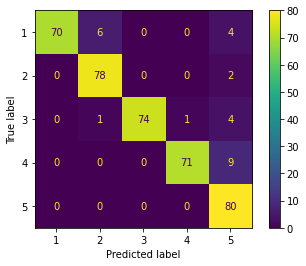

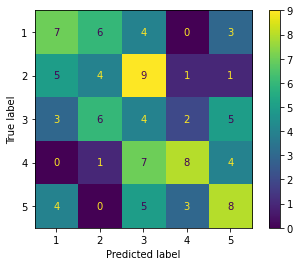

F1-score for training set 0.9325
F1-score for testing set 0.31


In [15]:
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, f1_score

classifier = SVC(kernel='poly')
classifier.fit(embed_train,labels_train)

plot_confusion_matrix(classifier, embed_train,labels_train)
plot_confusion_matrix(classifier, embed_test,labels_test)
plt.show()

pred_train_set = np.array(classifier.predict(embed_train).reshape(-1,1))
pred_test_set = np.array(classifier.predict(embed_test).reshape(-1,1))

print("F1-score for training set",f1_score(labels_train,pred_train_set, average='micro'))
print("F1-score for testing set",f1_score(labels_test,pred_test_set, average='micro'))

### TfIdf Encoding D) [10 points]

Discuss the performance of the TfIdf Embeddings for this task compared to the performance of the One Hot Embeddings. Which one is better? Why?

Comparing the performances between One Hot Embendings and Tfldf showed that Tfldf performed well because this approach weights more on the rareness of tokens in the document compared to One Hot Embedding method which consides frequencies of tokens across the corpus. This Tfldf generally addresses the problem of stop words.